In [1]:
import numpy as np
import scipy.linalg
from collections import defaultdict, namedtuple, Counter
from itertools import combinations
import numpy as np
import scipy.stats as stats
import sys
from os import listdir
import json
import random
import csv
import matplotlib.pyplot as plt


In [51]:
dataset_name = 'spark'
dataset_dir = '../../PhasingFamilies/recomb_spark'
ped_file = '../../DATA/spark/sparkfam.ped.quads.ped'
#interval_chrom, interval_start_pos, interval_end_pos = '7', 4101620, 4747462
#interval_chrom, interval_start_pos, interval_end_pos = '19', 3604269, 3718439
interval_chrom, interval_start_pos, interval_end_pos = '18', None, None
crunch = False
num_trials = 1000
na = 2
flip = False

In [52]:
# pull phenotype data
sample_to_affected, sample_to_sex = dict(), dict()
with open(ped_file, 'r') as f:
	for line in f:
		pieces = line.strip().split('\t')
		sample_to_sex[pieces[1]] = pieces[4]
		sample_to_sex[pieces[3]] = '2'
		sample_to_sex[pieces[2]] = '1'
		sample_to_affected[pieces[1]] = pieces[5]

In [53]:
with open('%s/sibpairs.json' % dataset_dir, 'r') as f:
	sibpairs = json.load(f)


def header_to_inds(header):
	header = header.strip().split('\t')
	return [header[i][:-4] for i in range(5, len(header)-3, 2)]


print('Overall')
print('families', len(set([x['family'].split('.')[0] for x in sibpairs])))
print('sibpairs', len(sibpairs))
#print('num_affected', Counter([x['num_affected'] for x in sibpairs]))

for sibpair in sibpairs:
	sibpair['num_affected'] = int(sample_to_affected[sibpair['sibling1']]=='2') + int(sample_to_affected[sibpair['sibling2']]=='2')

if na == 3:
	sibpairs = [x for x in sibpairs if x['num_affected']>0]
else:
	sibpairs = [x for x in sibpairs if x['num_affected']==na]
num_sibpairs = len(sibpairs)


print('Overall')
print('families', len(set([x['family'].split('.')[0] for x in sibpairs])))
print('sibpairs', len(sibpairs))
#print('num_affected', Counter([x['num_affected'] for x in sibpairs]))


Overall
families 5579
sibpairs 6926
Overall
families 1166
sibpairs 1473


In [54]:
#with open('permutation_tests/%s.%d.%ssibpairs.json' % (dataset_name, na, 'flip.' if flip else ''), 'w+') as f:
#	json.dump(sibpairs, f)

In [73]:
def apply_interval_filter(chrom, start_pos, end_pos):
	if interval_start_pos is not None or interval_end_pos is not None:
		start_pos = np.clip(start_pos, interval_start_pos, interval_end_pos)
		end_pos = np.clip(end_pos, interval_start_pos, interval_end_pos)
	is_ok = ((interval_chrom is None and chrom != 'X') or interval_chrom == chrom) and (end_pos-start_pos>0)
	return is_ok, start_pos, end_pos

def process_phase_file(sibpair):
	with open('../../PhasingFamilies/%s/%s.phased.txt' % (sibpair['phase_dir'], sibpair['family']), 'r')  as f:
		header = next(f) # skip header
		inds = header_to_inds(header)
		sib1_ind_index, sib2_ind_index = inds.index(sibpair['sibling1']), inds.index(sibpair['sibling2'])
		sib1_mat_index, sib2_mat_index = 4+(2*sib1_ind_index), 4+(2*sib2_ind_index)
		sib1_pat_index, sib2_pat_index = 5+(2*sib1_ind_index), 5+(2*sib2_ind_index)
		sib_phase_indices = [sib1_mat_index, sib2_mat_index, sib1_pat_index, sib2_pat_index]

		current_chrom, current_start_pos, current_end_pos, current_state = None, None, None, None
		for line in f:
			pieces = line.strip().split('\t')
			chrom = pieces[0][3:]
			start_pos, end_pos = [int(x) for x in pieces[-2:]]
			state = np.array([int(x) for x in pieces[1:-2]])[sib_phase_indices]
			if pieces[-3]!='0':
				state[:] = -1

			if current_chrom is None:
				current_chrom, current_start_pos, current_end_pos, current_state = chrom, start_pos, end_pos, state
			elif current_chrom != chrom or np.any(current_state != state):
				is_ok, current_start_pos, current_end_pos = apply_interval_filter(current_chrom, current_start_pos, current_end_pos)
				if is_ok:
					yield current_chrom, current_start_pos, current_end_pos, current_state
				current_chrom, current_start_pos, current_end_pos, current_state = chrom, start_pos, end_pos, state
			else:
				current_end_pos = end_pos
		is_ok, current_start_pos, current_end_pos = apply_interval_filter(current_chrom, current_start_pos, current_end_pos)
		if is_ok:
			yield current_chrom, current_start_pos, current_end_pos, current_state

# pull intervals
positions = set()
for sibpair in sibpairs:
	#print(sibpair)
	for chrom, start_pos, end_pos, state in process_phase_file(sibpair):
		#print(chrom, start_pos, end_pos, state)
		positions.add((chrom, start_pos))
		positions.add((chrom, end_pos))

positions = sorted(positions, key=lambda x: (int(x[0]), x[1]) if x[0].isdigit() else (23, x[1]))
chroms, interval_starts, interval_ends = [], [], []
prev_chrom, prev_pos = None, None
for c, p in positions:
	if prev_chrom is not None and prev_chrom == c:
		chroms.append(c)
		interval_starts.append(prev_pos)
		interval_ends.append(p)
	prev_chrom, prev_pos = c, p


interval_starts = np.array(interval_starts)
interval_ends = np.array(interval_ends)
num_intervals = len(interval_starts)
print('intervals', num_intervals)
#print(interval_starts)
#print(interval_ends)
#print(interval_ends-interval_starts)

intervals 7158


In [56]:
# pull sibpair IBD

# sibpair, interval
is_mat_match = np.zeros((num_sibpairs, num_intervals), dtype=int)
is_pat_match = np.zeros((num_sibpairs, num_intervals), dtype=int)

interval_start_to_index = dict([((chrom, x), i) for i, (chrom, x) in enumerate(zip(chroms, interval_starts))])
interval_end_to_index = dict([((chrom, x), i) for i, (chrom, x) in enumerate(zip(chroms, interval_ends))])

for sibpair_index, sibpair in enumerate(sibpairs):
	for chrom, start_pos, end_pos, state in process_phase_file(sibpair):
		start_index, end_index = interval_start_to_index[(chrom, start_pos)], interval_end_to_index[(chrom, end_pos)]+1

		if state[0]==-1 or state[1]==-1:
			pass
		elif ((state[0]==state[1]) and (sibpair['num_affected']==0 or sibpair['num_affected']==2)) or \
		     ((state[0]!=state[1]) and (sibpair['num_affected']==1)):
			is_mat_match[sibpair_index, start_index:end_index] = 1
		else:
			is_mat_match[sibpair_index, start_index:end_index] = -1
			
		if state[2]==-1 or state[3]==-1:
				pass
		elif ((state[2]==state[3]) and (sibpair['num_affected']==0 or sibpair['num_affected']==2)) or \
		     ((state[2]!=state[3]) and (sibpair['num_affected']==1)):
			is_pat_match[sibpair_index, start_index:end_index] = 1
		else:
			is_pat_match[sibpair_index, start_index:end_index] = -1


is_ok = interval_ends - interval_starts > 1
interval_starts = interval_starts[is_ok]
interval_ends = interval_ends[is_ok]
chroms = np.array([23 if c=='X' else int(c) for c in chroms])[is_ok]
is_mat_match = is_mat_match[:, is_ok]
is_pat_match = is_pat_match[:, is_ok]
num_intervals = np.sum(is_ok)

In [57]:
if crunch:
	is_mat_match_new = np.zeros((is_mat_match.shape[0], 1))
	frac_ibd_mat = is_mat_match.dot((interval_ends-interval_starts))/np.sum(interval_ends-interval_starts)
	is_mat_match_new[frac_ibd_mat>0] = 1
	is_mat_match_new[frac_ibd_mat<0] = -1

	is_pat_match_new = np.zeros((is_pat_match.shape[0], 1))
	frac_ibd_pat = is_pat_match.dot((interval_ends-interval_starts))/np.sum(interval_ends-interval_starts)
	is_pat_match_new[frac_ibd_pat>0] = 1
	is_pat_match_new[frac_ibd_pat<0] = -1

	is_mat_match = is_mat_match_new
	is_pat_match = is_pat_match_new

	num_intervals = 1

	interval_starts = np.array([interval_start_pos])
	intervals_ends = np.array([interval_end_pos])
	chroms = np.array([23 if interval_chrom=='X' else int(interval_chrom)])
	

In [58]:
#np.save('permutation_tests/%s.%d.%sis_mat_match.npy' % (dataset_name, na, 'flip.' if flip else ''), is_mat_match)
#np.save('permutation_tests/%s.%d.%sis_pat_match.npy' % (dataset_name, na, 'flip.' if flip else ''), is_pat_match)


In [59]:
print(is_mat_match.shape, is_pat_match.shape)

# take into account sibling structure across quads
individuals = sorted(set([x['sibling1'] for x in sibpairs] + [x['sibling2'] for x in sibpairs]))
ind_to_index = dict([(x, i) for i, x in enumerate(individuals)])
sibling1_indices = np.array([ind_to_index[x['sibling1']] for x in sibpairs])
sibling2_indices = np.array([ind_to_index[x['sibling2']] for x in sibpairs])

A = np.random.randint(0, high=2, size=(num_trials+1, len(individuals), 2))
X1 = (A[:, sibling1_indices, 0] == A[:, sibling2_indices, 0]).astype(int)
X2 = (A[:, sibling1_indices, 1] == A[:, sibling2_indices, 1]).astype(int)

# randomly flip IBD in sibpairs
#X1 = np.random.randint(0, high=2, size=(num_trials+1, len(sibpairs)))
#X2 = np.random.randint(0, high=2, size=(num_trials+1, len(sibpairs)))

X1[X1==0] = -1
X2[X2==0] = -1

# first entry is actual IBD relationships
X1[0, :] = 1
X2[0, :] = 1

print('ready')

if interval_chrom is not None:
	dataset_name += '.chr%s' % interval_chrom
if interval_start_pos is not None or interval_end_pos is not None:
	dataset_name += '.%d-%d' % (interval_start_pos, interval_end_pos)

# trial, interval, mat/pat
rand_pvalue = np.zeros((num_trials+1, num_intervals, 4), dtype=int)



(1473, 5929) (1473, 5929)
ready


In [67]:
print(na, 'mat')
rand_pvalue[:, :, 0] = X1.dot(is_mat_match)
print(na, 'pat')
rand_pvalue[:, :, 1] = X2.dot(is_pat_match)
print(na, 'both')
rand_pvalue[:, :, 2] = rand_pvalue[:, :, 0]+rand_pvalue[:, :, 1]

2 mat
2 pat
2 both


In [61]:
print(na, 'cross')

for i in range(num_trials+1):
	rand_pvalue[i, :, 3] = np.sum((np.multiply(np.tile(X1[i, :], (is_mat_match.shape[1], 1)).T, is_mat_match)==1) & \
                                  (np.multiply(np.tile(X2[i, :], (is_pat_match.shape[1], 1)).T, is_pat_match)==1), axis=0)
	if i%100==0:
		print(i, end=' ')


2 cross
0 100 200 300 400 500 600 700 800 900 1000 

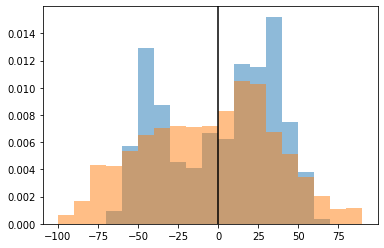

In [76]:
plt.hist(rand_pvalue[0, :, 0].flatten(), bins=np.arange(-100, 100, 10), alpha=0.5, density=True)
plt.hist(rand_pvalue[1:10, :, 0].flatten(), bins=np.arange(-100, 100, 10), alpha=0.5, density=True)
plt.axvline(0, color='black')
plt.show()

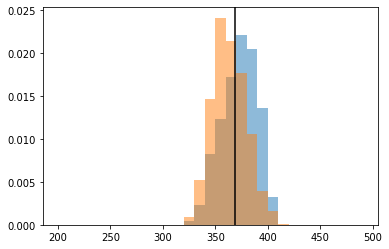

In [62]:
plt.hist(rand_pvalue[0, :, 3].flatten(), bins=np.arange(200, 500, 10), alpha=0.5, density=True)
plt.hist(rand_pvalue[1:10, :, 3].flatten(), bins=np.arange(200, 500, 10), alpha=0.5, density=True)
plt.axvline(len(sibpairs)/4, color='black')
plt.show()

In [63]:
# we expect to see less IBD sharing between discordant sibpairs
if flip:
	rand_pvalue = -rand_pvalue

In [64]:
# -------------------- implementing Westfall-Young max T stepdown procedure

# indices are sorted along interval axis from interval with most IBD sharing
# to least IBD sharing
final_pvalues = np.zeros((num_intervals, 4))
for is_mat in range(4):

	orig_indices = np.flip(np.argsort(rand_pvalue[0, :, is_mat]))

	max_t_k = np.zeros((num_trials+1, num_intervals+1))
	max_t_k[:, -1] = np.min(rand_pvalue[:, :, is_mat], axis=1)
	for i, j in list(reversed(list(enumerate(orig_indices)))):
		max_t_k[:, i] = np.maximum(max_t_k[:, i+1], rand_pvalue[:, j, is_mat])
	max_t_k = max_t_k[:, :-1]

	#max_t_k = np.flip(np.sort(rand_pvalue[:, :, is_mat], axis=1), axis=1)
	
	assert np.all(max_t_k[0, :] == rand_pvalue[0, orig_indices, is_mat])

	# calculate pi(j)
	pvalues = np.sum(max_t_k[1:, :] >= np.tile(max_t_k[0, :], (num_trials, 1)), axis=0)/num_trials
	pvalues = np.array([np.max(pvalues[:(i+1)]) for i in np.arange(pvalues.shape[0])])
	final_pvalues[orig_indices, is_mat] = pvalues

In [48]:
print(final_pvalues[:, 3])

[0. 0. 0. ... 0. 0. 0.]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


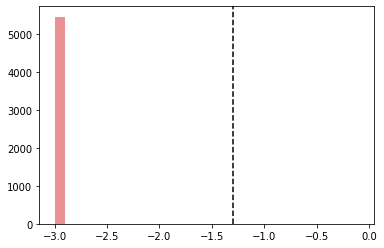

In [49]:
plt.hist(np.clip(np.log10(final_pvalues[:, 0]), -3, None), alpha=0.5, bins=np.arange(-3, 0, 0.1))
plt.hist(np.clip(np.log10(final_pvalues[:, 1]), -3, None), alpha=0.5, bins=np.arange(-3, 0, 0.1))
plt.hist(np.clip(np.log10(final_pvalues[:, 2]), -3, None), alpha=0.5, bins=np.arange(-3, 0, 0.1))
plt.hist(np.clip(np.log10(final_pvalues[:, 3]), -3, None), alpha=0.5, bins=np.arange(-3, 0, 0.1))
plt.axvline(np.log10(0.05), color='black', linestyle='--')
plt.show()